<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Evaluating-Shot-Boundaries" data-toc-modified-id="Evaluating-Shot-Boundaries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Evaluating Shot Boundaries</a></span><ul class="toc-item"><li><span><a href="#Algorithm-1:-Greedy-Search" data-toc-modified-id="Algorithm-1:-Greedy-Search-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Algorithm 1: Greedy Search</a></span></li><li><span><a href="#Algorithm-2:-Greedy-Search-with-Replacement" data-toc-modified-id="Algorithm-2:-Greedy-Search-with-Replacement-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Algorithm 2: Greedy Search with Replacement</a></span></li><li><span><a href="#Statistics-on-Shot-Length" data-toc-modified-id="Statistics-on-Shot-Length-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Statistics on Shot Length</a></span></li><li><span><a href="#Implementations" data-toc-modified-id="Implementations-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Implementations</a></span><ul class="toc-item"><li><span><a href="#Algorithm-1-Implementation" data-toc-modified-id="Algorithm-1-Implementation-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Algorithm 1 Implementation</a></span></li><li><span><a href="#Algorithm-2-Implemenation" data-toc-modified-id="Algorithm-2-Implemenation-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Algorithm 2 Implemenation</a></span></li></ul></li><li><span><a href="#Evaluating-Algorithms" data-toc-modified-id="Evaluating-Algorithms-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Evaluating Algorithms</a></span><ul class="toc-item"><li><span><a href="#Algorithm-1" data-toc-modified-id="Algorithm-1-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Algorithm 1</a></span></li><li><span><a href="#Algorithm-2" data-toc-modified-id="Algorithm-2-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Algorithm 2</a></span></li></ul></li></ul></li></ul></div>

In [1]:
from esper.rekall import *
from rekall.video_interval_collection import VideoIntervalCollection
from query.models import Video, Shot
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load shot boundaries from database
video_ids = [123, 186, 188, 377]
eval_interval_collection = VideoIntervalCollection.from_django_qs(
    Shot.objects.filter(video_id__in=video_ids, labeler_id=3)
)
cutting_interval_collection = VideoIntervalCollection.from_django_qs(
    Shot.objects.filter(video_id__in=video_ids, labeler_id=10)
)

# Evaluating Shot Boundaries
This is a notebook for evaluating precision/recall of shot boundaries against ground truth. For ground truth, we use James Cutting's annotations. Unfortunately, his annotations have a few problems that make working with them directly a little difficult:
* In Cutting's annotations, "Shot 1" starts after studio logos, so it doesn't start at the beginning of the movie
* Sometimes, it's not clear where "Shot 1" starts; in the Star Wars movies, for instance, it's sometimes difficult to tell if the shots begin before or after the initial plot description
* By the end of the movie, the shot annotations are consistently 1-2 seconds off, even taking earlier offsets into account

Because of these reasons, it's difficult to precisely compute precision/recall numbers for shot boundaries against Cutting's annotations. Given a set of shot boundaries we want to evaluate, we need to use some hueristics to determine which of Cutting's boundaries our shot boundaries correspond to. We have a few algorithms to compute these heuristics.

To start with, we evaluate our microshots vs. Cutting's shot annotations for four movies:
* Mr. & Mrs. Smith (2005)
* Star Wars: Episode III - Revenge of the Sith (2005)
* Star Wars: Episode V - The Empire Strikes Back (1980)
* Harry Potter and the Goblet of Fire (2005)

## Algorithm 1: Greedy Search
Map each Cutting shot boundary to the nearest shot boundary from the evaluation set that is close enough by some threshold (such as two seconds). Each boundary in the evaluation set can only be mapped to by a single Cutting shot boundary. If no such boundary exists, mark the Cutting shot boundary as a "missed" boundary. Recall is `# of non-missed Cutting boundaries / total # of Cutting boundaries`, and precision is `# of evaluation shot boundaries that have a Cutting mapping / total # of evaluation shot boundaries`.

This algorithm can run into problems when it assigns Cutting shot boundaries to the wrong shot boundaries in the evaluation set.

## Algorithm 2: Greedy Search with Replacement
This algorithm is like the greedy one, except we allow multiple Cutting boundaries to be mapped to the same evaluation shot boundary. Note that this is **not** an accurate representation of precision, but it does give us an upper bound on recall.

## Statistics on Shot Length
Before we try to match our shot boundaries to Cutting's boundaries, let's start by computing some statistics on how badly our shot durations differ from James Cutting's shot durations.

In [3]:
def graph_shot_durations(n_bins):
    for video_id in video_ids:
        title = Video.objects.get(pk=video_id).name
        eval_intervallist = eval_interval_collection.get_intervallist(video_id)
        cutting_intervallist = cutting_interval_collection.get_intervallist(video_id)
        eval_durations = sorted([interval.length() for interval in eval_intervallist.get_intervals()])
        cutting_durations = sorted([interval.length() for interval in cutting_intervallist.get_intervals()])
        
        ax = plt.gca()
        ax.hist([eval_durations, cutting_durations], n_bins, histtype='bar',
                 label=['Computed Durations', 'Ground Truth Durations'])
        ax.legend()
        ax.set_title(title)
        plt.show()

def movingaverage(values, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(values, window, 'same')
        
def graph_moving_averages(window_size):
    for video_id in video_ids:
        title = Video.objects.get(pk=video_id).name
        eval_intervallist = eval_interval_collection.get_intervallist(video_id)
        cutting_intervallist = cutting_interval_collection.get_intervallist(video_id)
        
        eval_x = [interval.get_start() for interval in eval_intervallist.get_intervals()]
        cutting_x = [interval.get_start() for interval in cutting_intervallist.get_intervals()]
        eval_durations = [interval.length() for interval in eval_intervallist.get_intervals()]
        cutting_durations = [interval.length() for interval in cutting_intervallist.get_intervals()]
        
        eval_avg = movingaverage(eval_durations, window_size)
        cutting_avg = movingaverage(cutting_durations, window_size)
        
        ax = plt.gca()
        ax.plot(eval_x, eval_avg, label='Computed Durations')
        ax.plot(cutting_x, cutting_avg, label='Ground Truth Durations')
        ax.legend()
        ax.set_title(title)
        plt.show()

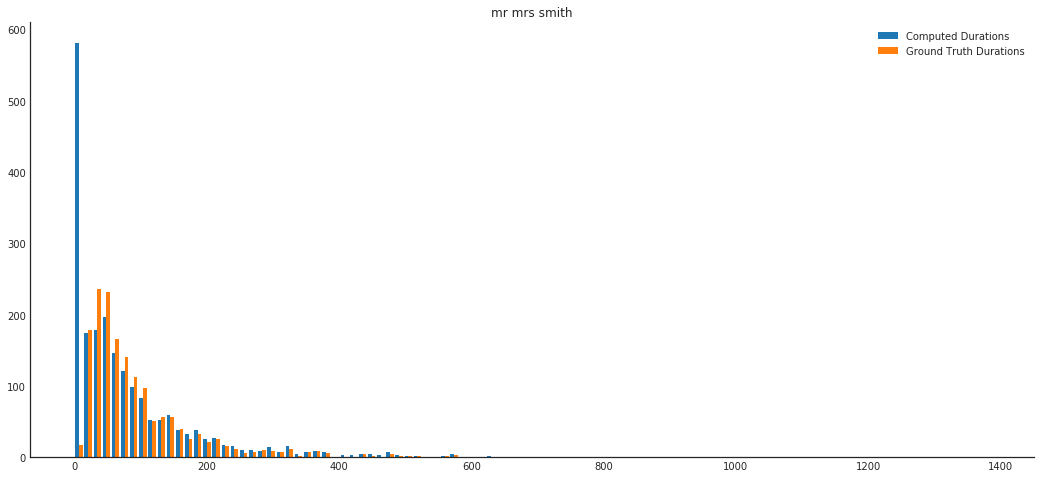

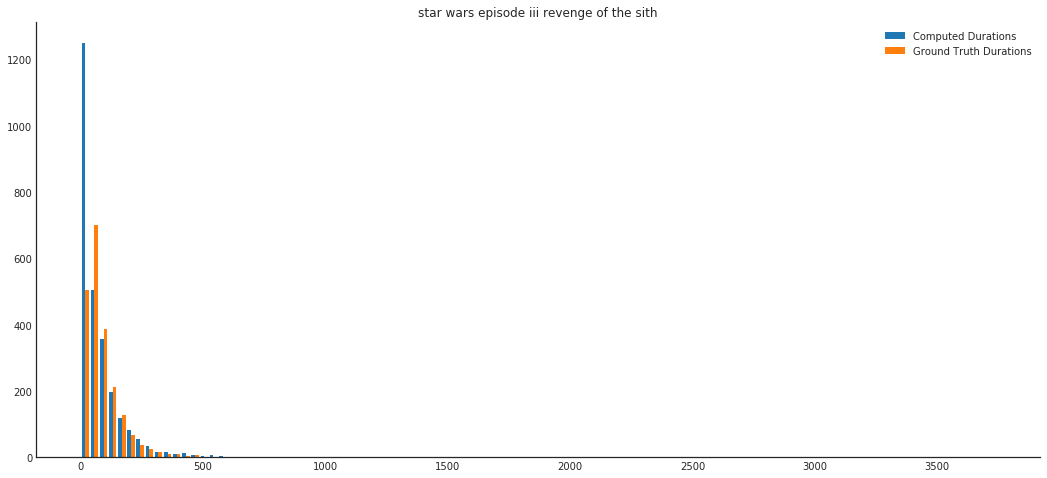

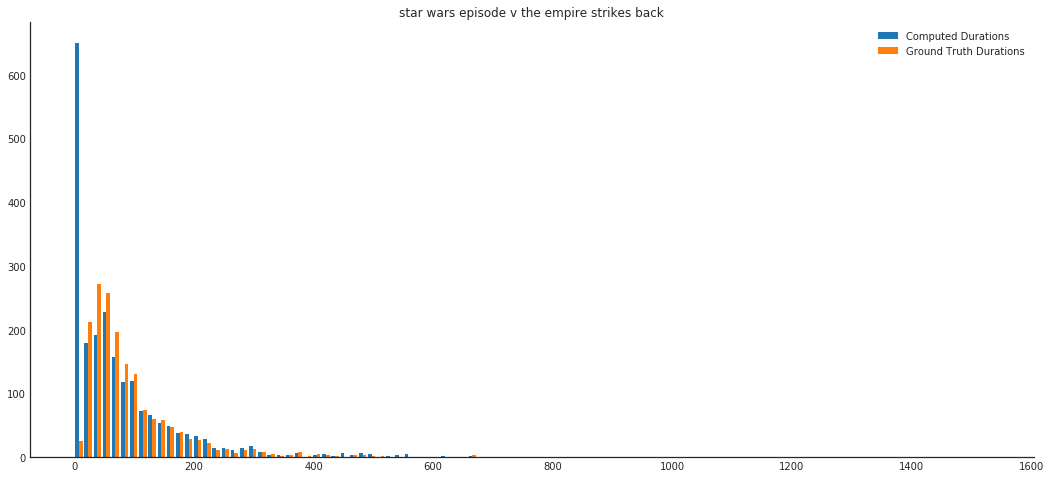

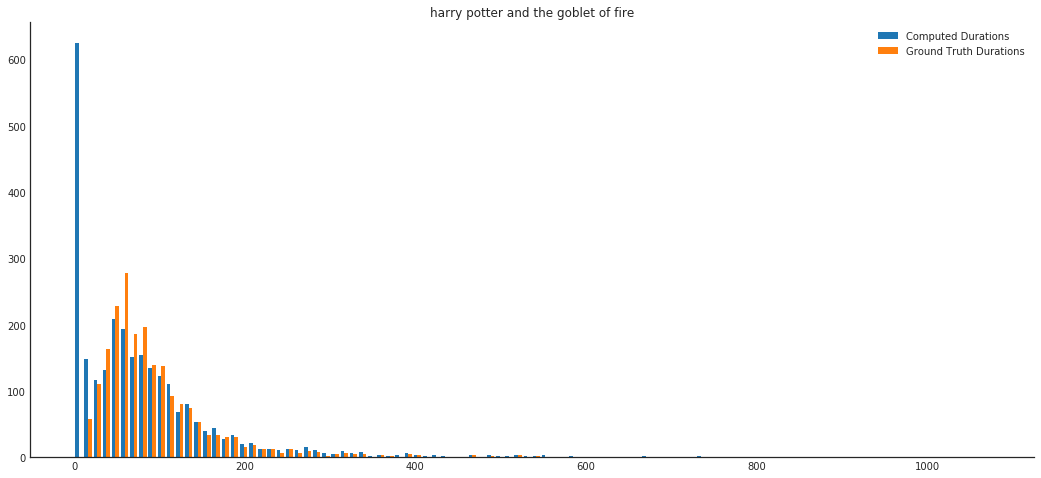

In [4]:
graph_shot_durations(100)

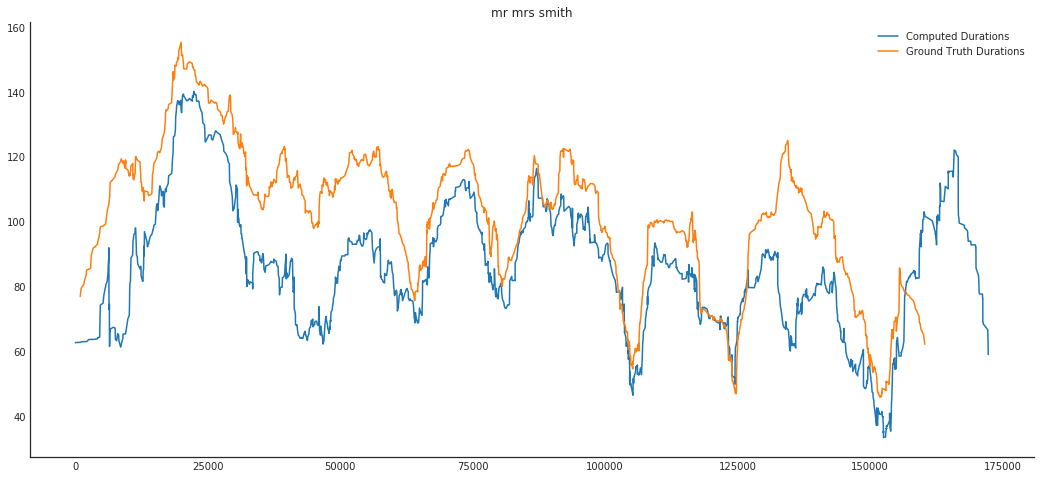

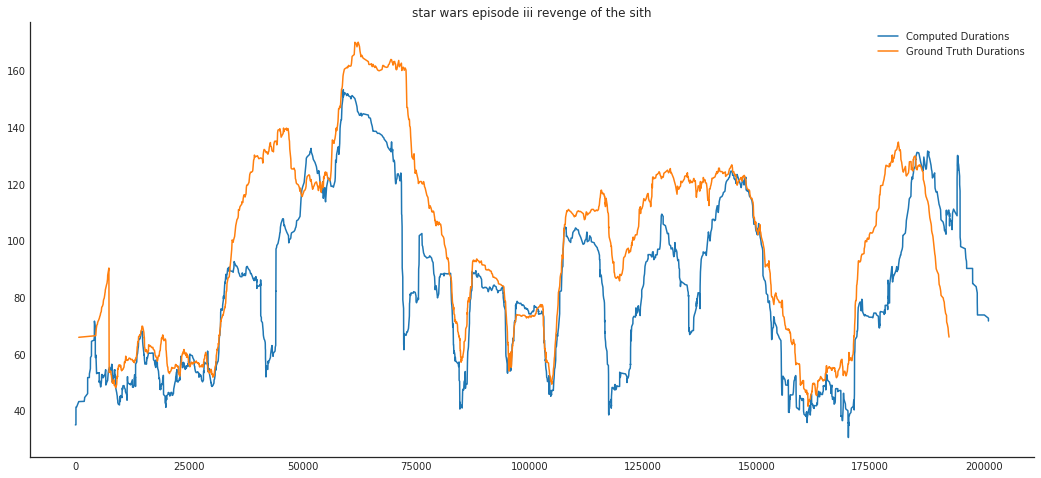

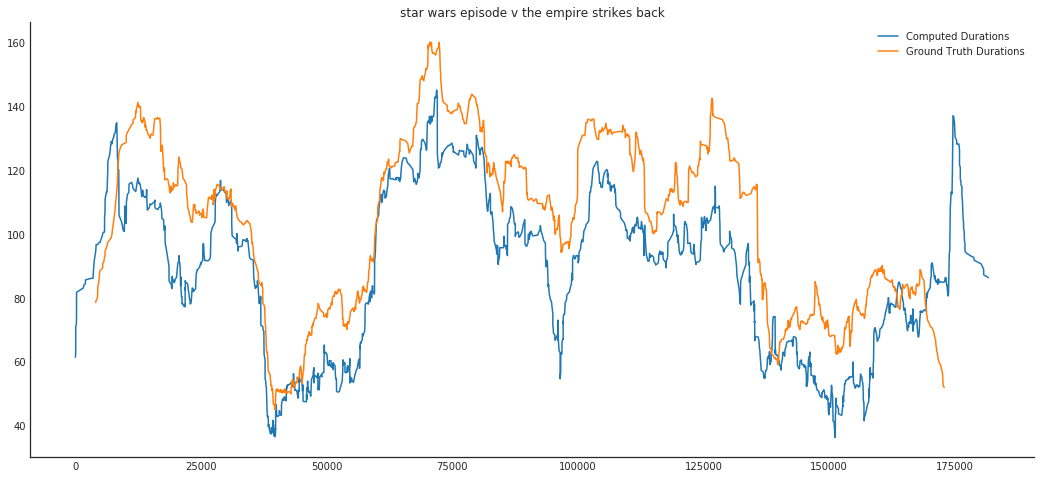

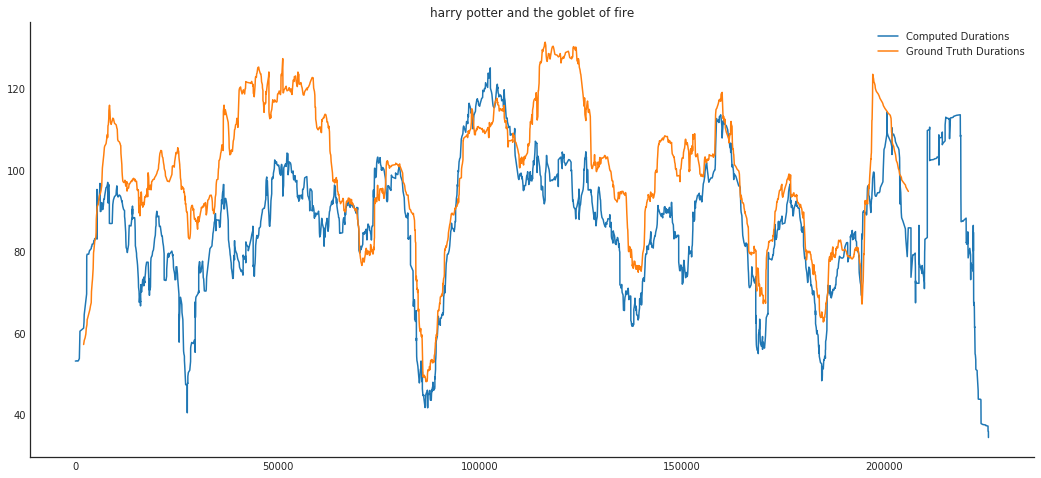

In [5]:
graph_moving_averages(100)

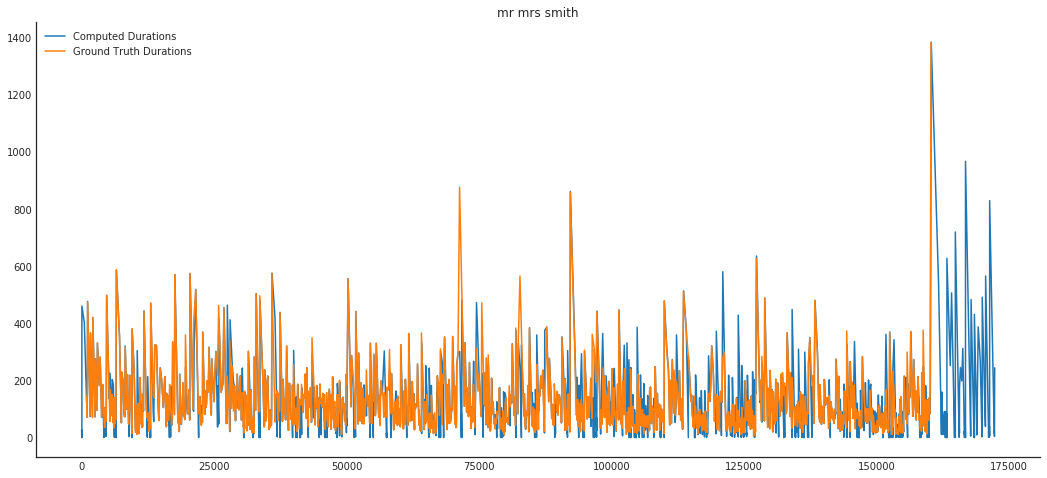

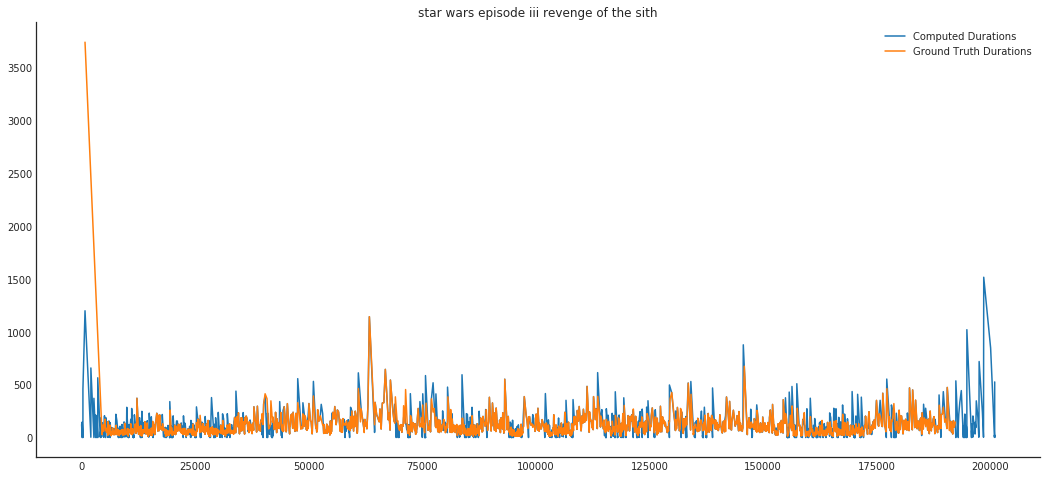

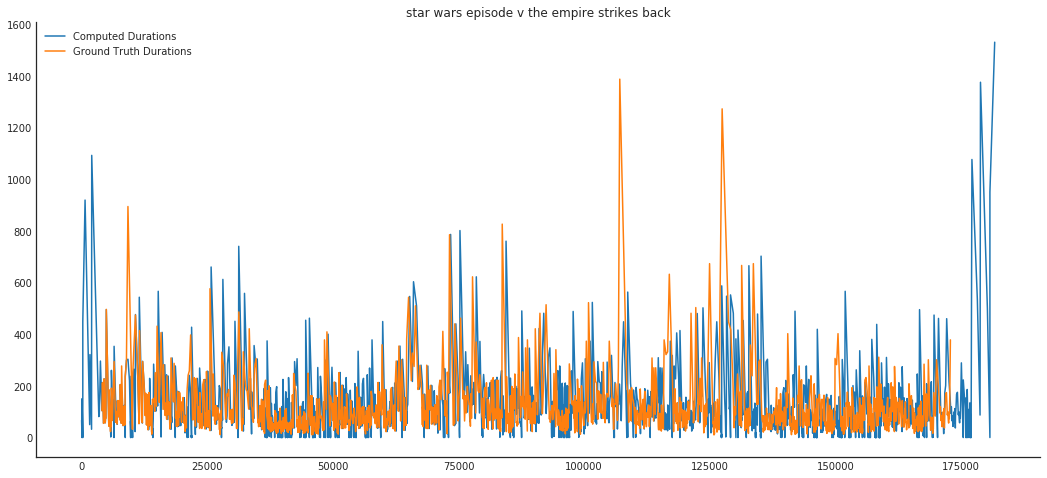

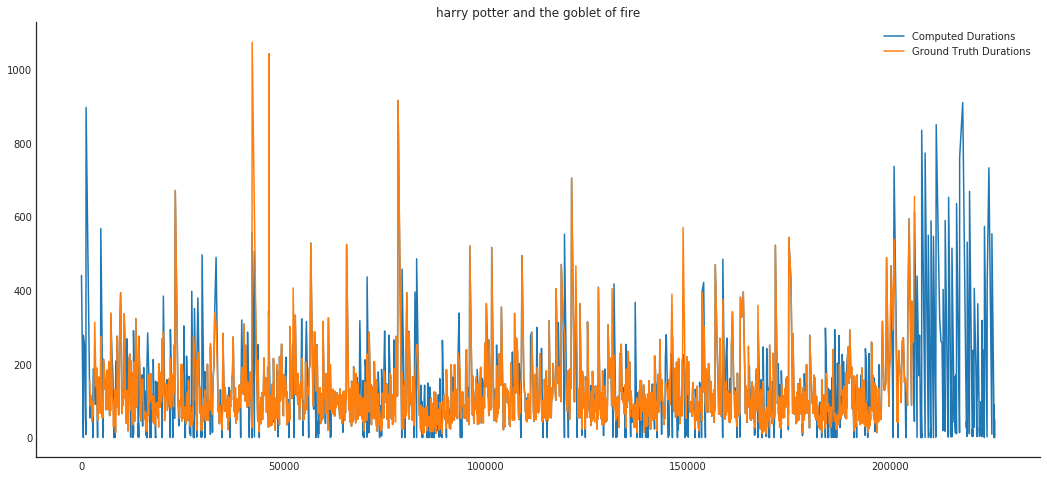

In [6]:
graph_moving_averages(1)

## Implementations

In [7]:
# Calculate precision/recall from algorithm results
def precision_recall(eval_intervallist, cutting_intervallist, algorithm, threshold=48):
    valid, used_eval, matched_cutting = algorithm(eval_intervallist, cutting_intervallist, threshold)
    precision = len(used_eval) / len(valid)
    recall = len(matched_cutting) / len(cutting_intervallist.get_intervals())
    return precision, recall

def print_precision_recall(precision_recall):
    print('Precision:', precision_recall[0])
    print('Recall:', precision_recall[1])

### Algorithm 1 Implementation

In [8]:
# Greedy Search precision/recall
def greedy_match(eval_intervallist, cutting_intervallist, threshold=48):
    '''
    eval_intervallist and cutting_intervallist are IntervalLists.
    threshold is the threshold to search nearby.
    
    Returns tuple of:
    * list of eval boundaries (start times only) within Cutting's
      boundaries +/- threshold
    * list of eval boundaries that have a matching Cutting boundary
    * list of Cutting boundaries that have a matching eval boundary
    '''
    min_start = cutting_intervallist.get_intervals()[0].get_start()
    max_end = cutting_intervallist.get_intervals()[-1].get_end() + threshold
    
    # construct ordered list of valid eval boundaries
    valid_eval_boundaries = [
        interval.get_start()
        for interval in eval_intervallist.get_intervals()
        if interval.get_start() >= min_start and interval.get_start() <= max_end
    ]
    
    # construct ordered list of cutting boundaries
    cutting_boundaries = [
        interval.get_start()
        for interval in cutting_intervallist.get_intervals()
    ]
    
    used_eval_boundaries = set()
    matched_cutting_boundaries = set()
    for boundary in cutting_boundaries:
        best_eval = None
        for eval_boundary in valid_eval_boundaries:
            if eval_boundary + threshold < boundary:
                continue
            if eval_boundary - threshold > boundary:
                break
            if eval_boundary in used_eval_boundaries:
                continue
            if (best_eval is None or
                abs(boundary - eval_boundary) < abs(boundary - best_eval)):
                best_eval = eval_boundary
        if best_eval is not None:
            used_eval_boundaries.add(best_eval)
            matched_cutting_boundaries.add(boundary)
    
    return valid_eval_boundaries, sorted(list(used_eval_boundaries)), sorted(list(matched_cutting_boundaries))

### Algorithm 2 Implemenation

In [9]:
# Greedy Search with replacement
def greedy_match_with_replacement(eval_intervallist, cutting_intervallist, threshold=48):
    '''
    eval_intervallist and cutting_intervallist are IntervalLists.
    threshold is the threshold to search nearby.
    
    Returns tuple of:
    * list of eval boundaries (start times only) within Cutting's
      boundaries +/- threshold
    * list of eval boundaries that have a matching Cutting boundary
    * list of Cutting boundaries that have a matching eval boundary
    '''
    min_start = cutting_intervallist.get_intervals()[0].get_start()
    max_end = cutting_intervallist.get_intervals()[-1].get_end() + threshold
    
    # construct ordered list of valid eval boundaries
    valid_eval_boundaries = [
        interval.get_start()
        for interval in eval_intervallist.get_intervals()
        if interval.get_start() >= min_start and interval.get_start() <= max_end
    ]
    
    # construct ordered list of cutting boundaries
    cutting_boundaries = [
        interval.get_start()
        for interval in cutting_intervallist.get_intervals()
    ]
    
    used_eval_boundaries = set()
    matched_cutting_boundaries = set()
    for boundary in cutting_boundaries:
        best_eval = None
        for eval_boundary in valid_eval_boundaries:
            if eval_boundary + threshold < boundary:
                continue
            if eval_boundary - threshold > boundary:
                break
            if (best_eval is None or
                abs(boundary - eval_boundary) < abs(boundary - best_eval)):
                best_eval = eval_boundary
        if best_eval is not None:
            used_eval_boundaries.add(best_eval)
            matched_cutting_boundaries.add(boundary)
    
    return valid_eval_boundaries, sorted(list(used_eval_boundaries)), sorted(list(matched_cutting_boundaries))

## Evaluating Algorithms

In [10]:
def evaluate_precision_recall(algorithm, threshold):
    for video_id in video_ids:
        print(Video.objects.get(pk=video_id).name)
        print_precision_recall(precision_recall(
            eval_interval_collection.get_intervallist(video_id),
            cutting_interval_collection.get_intervallist(video_id),
            algorithm,
            threshold=threshold
        ))

In [25]:
def graph_precision_recall(algorithm, threshold):
    data = []
    for video_id in video_ids:
        name = Video.objects.get(pk=video_id).name
        precision, recall = precision_recall(
            eval_interval_collection.get_intervallist(video_id),
            cutting_interval_collection.get_intervallist(video_id),
            algorithm,
            threshold=threshold
        )
        data.append((precision, recall, name))
    
    precisions = [precision for precision, _, _ in data]
    recalls = [recall for _, recall, _ in data]
    names = [name for _, _, name in data]
    N = len(names)

    ax = plt.gca()
    
    width = 0.35
    ind = np.arange(N)
    p1 = ax.bar(ind, precisions, width)
    p2 = ax.bar(ind + width, recalls, width)
    
    ax.set_title('Precision and Recall by movie')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(names)
    ax.set_ylim((0, 1))
    
    ax.legend((p1[0], p2[0]), ('Precision', 'Recall'))
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%f' % height,
                    ha='center', va='bottom')

    autolabel(p1)
    autolabel(p2)
    
    plt.show()

In [12]:
def graph_inaccuracies(algorithm, threshold, n_bins):
    for video_id in video_ids:
        title = Video.objects.get(pk=video_id).name
        eval_intervallist = eval_interval_collection.get_intervallist(video_id)
        cutting_intervallist = cutting_interval_collection.get_intervallist(video_id)
        valid, used_eval, matched_cutting = algorithm(eval_intervallist, cutting_intervallist, threshold=threshold)
        inaccurate_eval = [boundary for boundary in valid if boundary not in used_eval]
        missed_shots = [interval.get_start()
                        for interval in cutting_intervallist.get_intervals()
                        if interval.get_start() not in matched_cutting]
        ax = plt.gca()
        ax.hist([inaccurate_eval, missed_shots], n_bins, histtype='bar',
                 label=['Inaccurate shot boundaries', 'Missed shot boundaries'])
        ax.legend()
        ax.set_title(title)
        plt.show()

### Algorithm 1

In [13]:
# Let's see raw precision/recall numbers
evaluate_precision_recall(greedy_match, 72)

mr mrs smith
Precision: 0.7263959390862944
Recall: 0.8811576354679803
star wars episode iii revenge of the sith
Precision: 0.6772954283519017
Recall: 0.8331758034026465
star wars episode v the empire strikes back
Precision: 0.5203641590800192
Recall: 0.6339754816112084
harry potter and the goblet of fire
Precision: 0.7641237113402062
Recall: 0.885755258126195


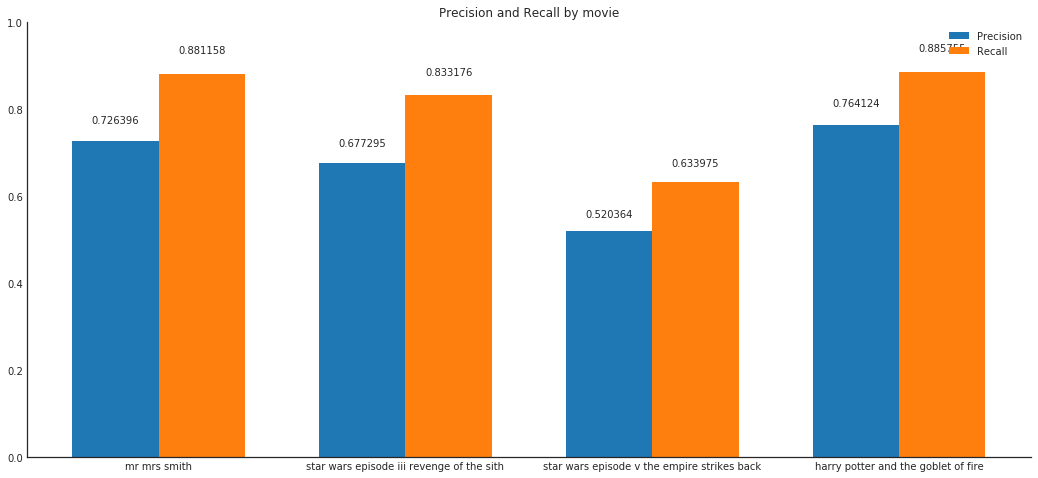

In [26]:
graph_precision_recall(greedy_match, 72)

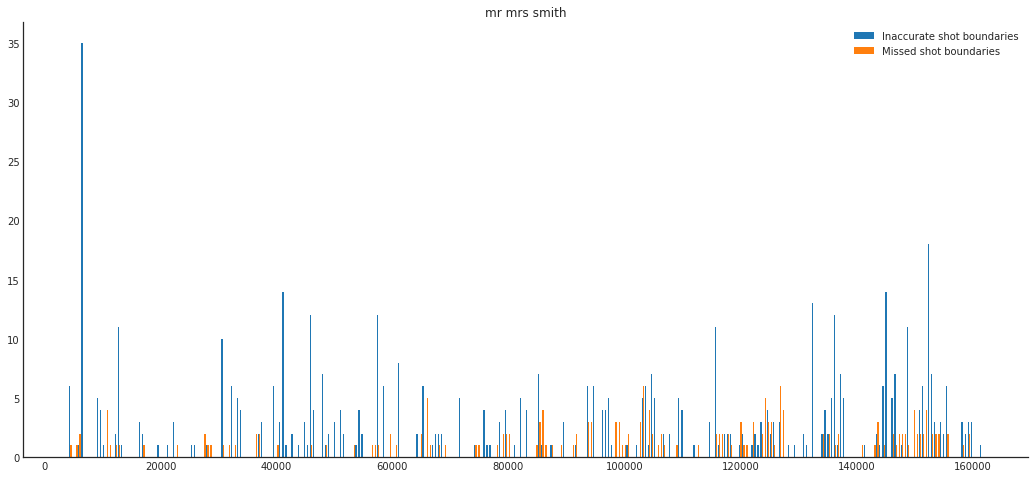

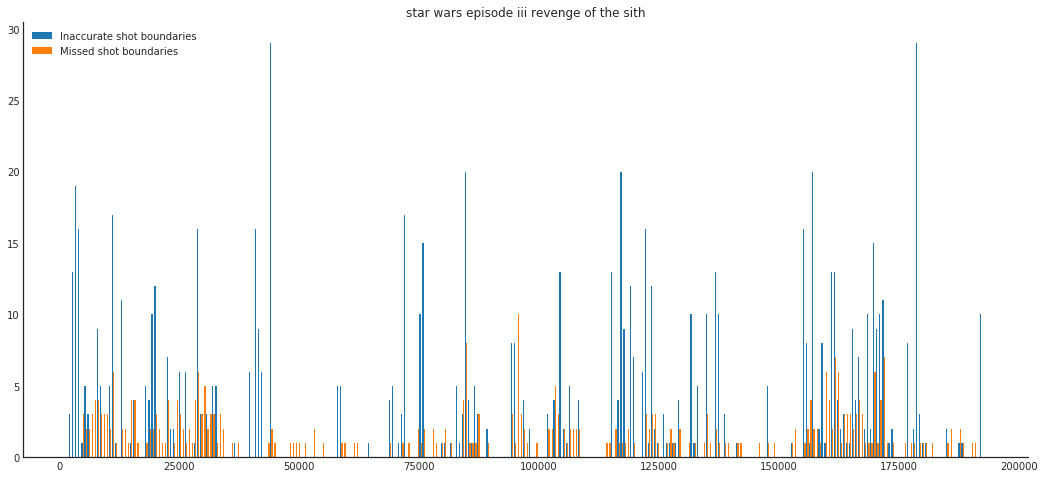

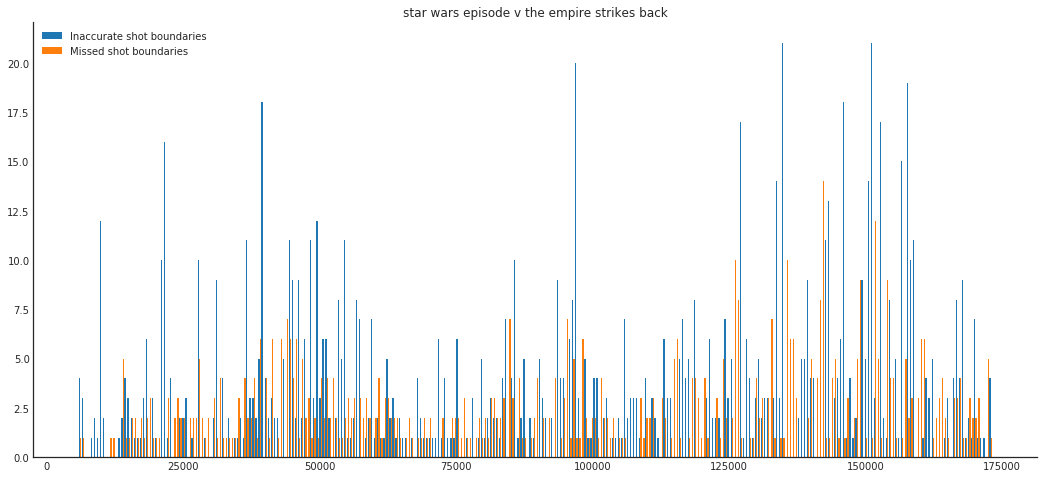

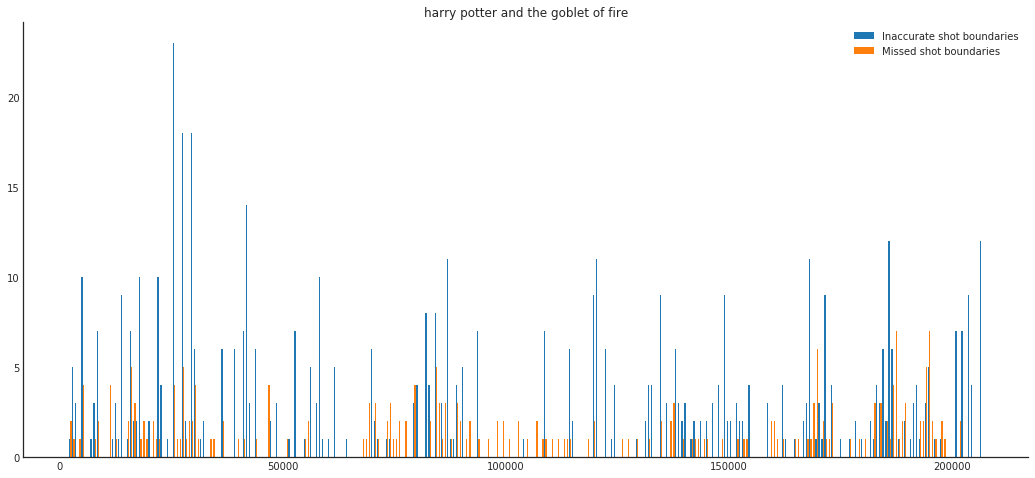

In [15]:
# Let's look at where our inaccuracies are
graph_inaccuracies(greedy_match, 72, 300)

### Algorithm 2

In [16]:
# Let's see raw precision/recall numbers
evaluate_precision_recall(greedy_match_with_replacement, 72)

mr mrs smith
Precision: 0.6375634517766497
Recall: 0.9556650246305419
star wars episode iii revenge of the sith
Precision: 0.6434882827506723
Recall: 0.9328922495274102
star wars episode v the empire strikes back
Precision: 0.4791566842357451
Recall: 0.7974314068884997
harry potter and the goblet of fire
Precision: 0.7418556701030928
Recall: 0.9526768642447419


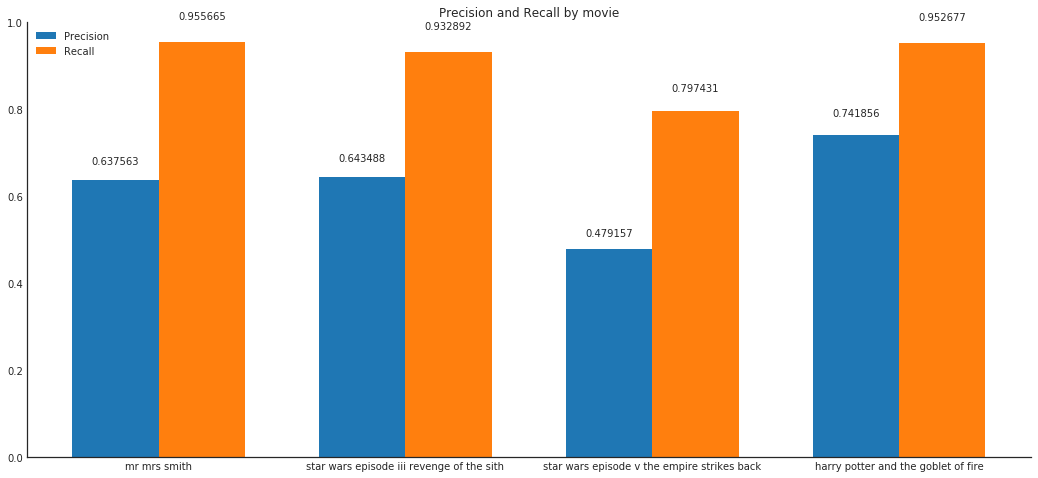

In [27]:
graph_precision_recall(greedy_match_with_replacement, 72)

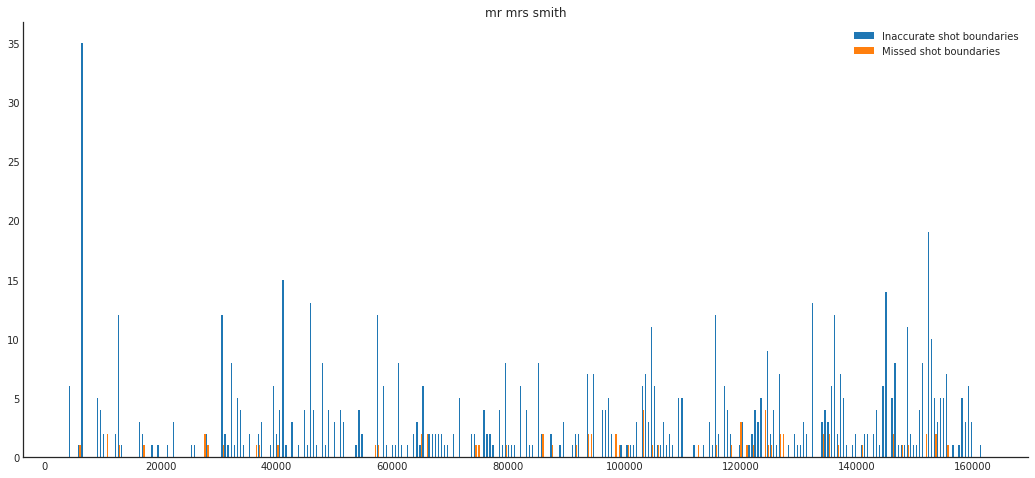

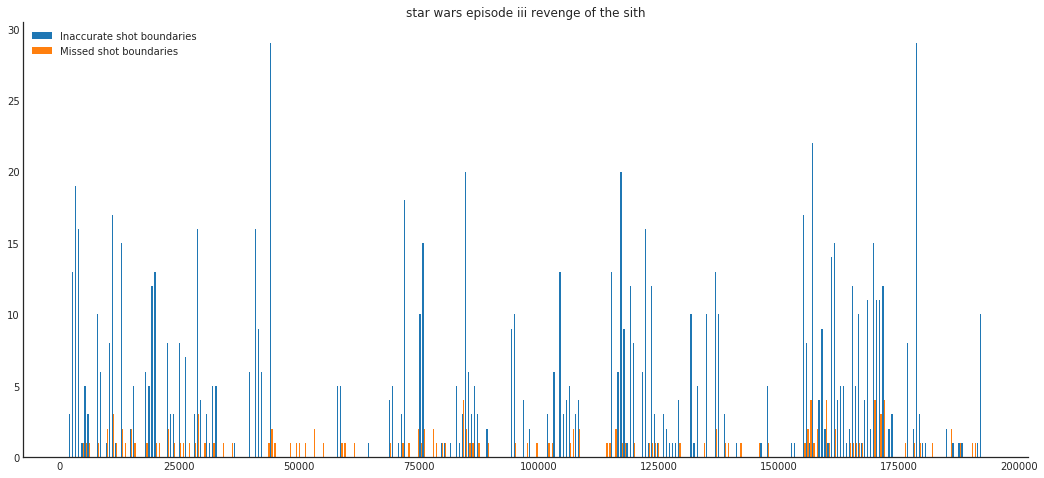

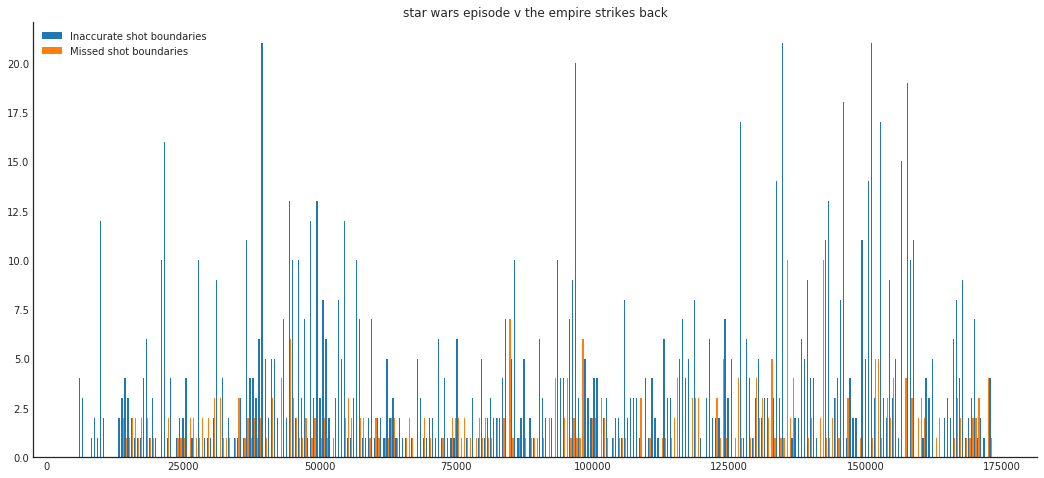

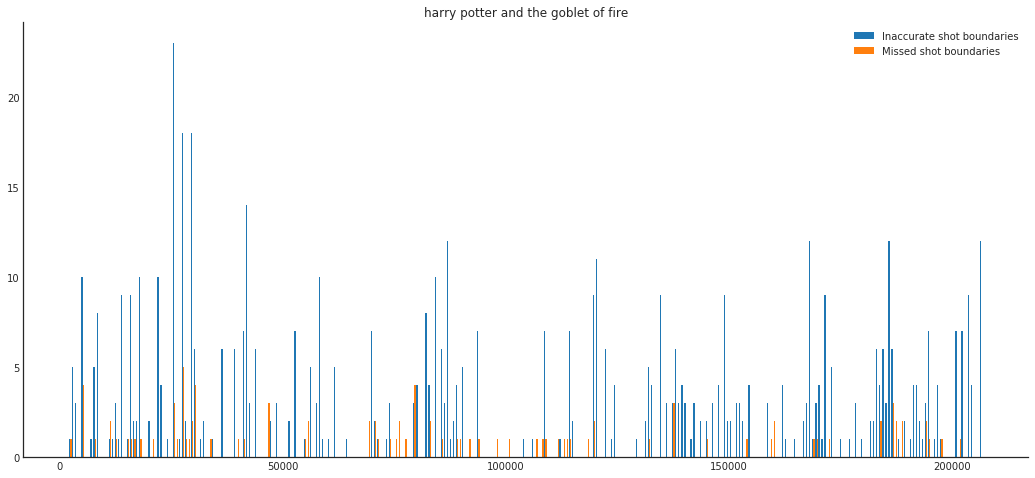

In [18]:
# Let's look at where our inaccuracies are
graph_inaccuracies(greedy_match_with_replacement, 72, 300)